# All-Star Game MVP Award Prediction Pipeline

## Setup and Data Loading

In [ ]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, log_loss, classification_report
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# Load data
awards_data = pd.read_csv("../../data/initial_data/awards_players.csv")
teams_data = pd.read_csv("../../data/initial_data/teams.csv")
players_teams_clean = pd.read_csv("../awards_data/players_teams_clean.csv")

## Create All-Star MVP Data

In [172]:
# Join dataset players_teams_clean data with teams_data
mvp_data = players_teams_clean.merge(
    teams_data[['year', 'tmID', 'won', 'lost', 'rank', 'playoff', 'confID']], 
    left_on=['year', 'team'], 
    right_on=['year', 'tmID'], 
    how='left'
)

# Rename columns for clarity
mvp_data.rename(columns={
    'won': 'team_wins', 
    'lost': 'team_losses', 
    'rank': 'conference_rank', 
    'playoff': 'playoff_made'
}, inplace=True)

# Drop the duplicate tmID column
mvp_data.drop(columns=['tmID'], inplace=True)

# Process categorical columns
mvp_data['playoff_made'] = mvp_data['playoff_made'].map({'Y': 1, 'N': 0})
mvp_data['confID'] = mvp_data['confID'].astype('category').cat.codes

# Add All-Star MVP winner field
target_award = 'All-Star Game Most Valuable Player'
mvp_winners = awards_data[awards_data['award'] == target_award][['year', 'playerID']]

mvp_data['MVP_winner'] = mvp_data.apply(
    lambda row: 1 if ((mvp_winners['year'] == row['year']) & 
                      (mvp_winners['playerID'] == row['playerID'])).any() else 0,
    axis=1
)

print(f"Data shape: {mvp_data.shape}")
print(f"All-Star MVP winners in dataset: {mvp_data['MVP_winner'].sum()}")

# Save csv
mvp_data.to_csv("all_star_mvp_data.csv", index=False)
print("✅ Saved to all_star_mvp_data.csv")

Data shape: (1876, 24)
All-Star MVP winners in dataset: 8
✅ Saved to all_star_mvp_data.csv


## Define Features and Prepare Data

In [ ]:
# Define feature columns for the model
# Using year N-1 stats to predict year N Award
feature_columns = [
    'minutes','games_played','total_points','total_rebounds','total_assists',
    'points_per_min','assists_per_min','rebounds_per_min','steals_per_min',
    'blocks_per_min','turnovers_per_min','FG%','FT%','Three%','Three Rate',
    'team_wins','team_losses','conference_rank','playoff_made','confID'
]
# Prepare dataset for training (Year N-1 Stats -> Year N Award)
data = pd.read_csv("all_star_mvp_data.csv")
data['next_year'] = data['year'] + 1

# Get winners for next year
winners_next_year = data[data['MVP_winner'] == 1][['year', 'playerID']].copy()
winners_next_year.rename(columns={'year': 'next_year'}, inplace=True)

# Merge to create target variable
data = data.merge(
    winners_next_year,
    on=['next_year', 'playerID'],
    how='left',
    indicator=True
)
data['Target'] = (data['_merge'] == 'both').astype(int)
data.drop(columns=['_merge'], inplace=True)

# Filter candidates
candidates = data[
    (data['minutes'] >= 500) &
    (data['games_played'] >= 20)
].copy()

print(f"Total candidates: {len(candidates)}")
print(f"Positive samples: {candidates['Target'].sum()}")

Total candidates: 866
Positive samples: 7


---
# Section 1: Single-Year Model Testing

## 1.1 Logistic Regression

In [ ]:
# Split data
# To predict award year 10, we filter by next_year = 10 (which contains year 9 stats)
# Training example: predict awards for years 2-9 (uses stats from years 1-8) -> train_award_years = [2, 3, 4, 5, 6, 7, 8, 9]
# Testing example: predict award for year 10 (using stats from year 9) -> test_award_year = 10
train_award_years = [2, 3, 4, 5, 6, 7, 8, 9]
test_award_year = 10

train_data = candidates[candidates['next_year'].isin(train_award_years)].copy()
test_data = candidates[candidates['next_year'] == test_award_year].copy()

X_train = train_data[feature_columns]
y_train = train_data['Target']
X_test = test_data[feature_columns]
y_test = test_data['Target']

print(f"Train samples: {len(X_train)} | Test samples: {len(X_test)}")
print(f"Train positives: {y_train.sum()} | Test positives: {y_test.sum()}")

Train samples: 687 | Test samples: 92
Train positives: 6 | Test positives: 1


In [175]:
# Train Logistic Regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
model.fit(X_train_scaled, y_train)

# Predictions
y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)
test_probs = model.predict_proba(X_test_scaled)[:, 1]

print("\n✅ Logistic Regression Model trained!")
print(f"Train accuracy: {accuracy_score(y_train, y_train_pred):.3f}")
print(f"Test accuracy: {accuracy_score(y_test, y_test_pred):.3f}")
print("\nClassification Report (Test):")
print(classification_report(y_test, y_test_pred))


✅ Logistic Regression Model trained!
Train accuracy: 0.878
Test accuracy: 0.859

Classification Report (Test):
              precision    recall  f1-score   support

           0       1.00      0.86      0.92        91
           1       0.07      1.00      0.13         1

    accuracy                           0.86        92
   macro avg       0.54      0.93      0.53        92
weighted avg       0.99      0.86      0.91        92



### Feature Importance (Logistic Regression)


Top 10 Most Important Features:
          feature  coefficient
        team_wins     2.080883
          minutes     2.054132
turnovers_per_min    -1.990803
     playoff_made    -1.849963
   total_rebounds     1.519258
              FG%    -1.389243
     games_played    -1.315124
  assists_per_min     1.157251
   steals_per_min    -1.113533
           Three%    -0.859855


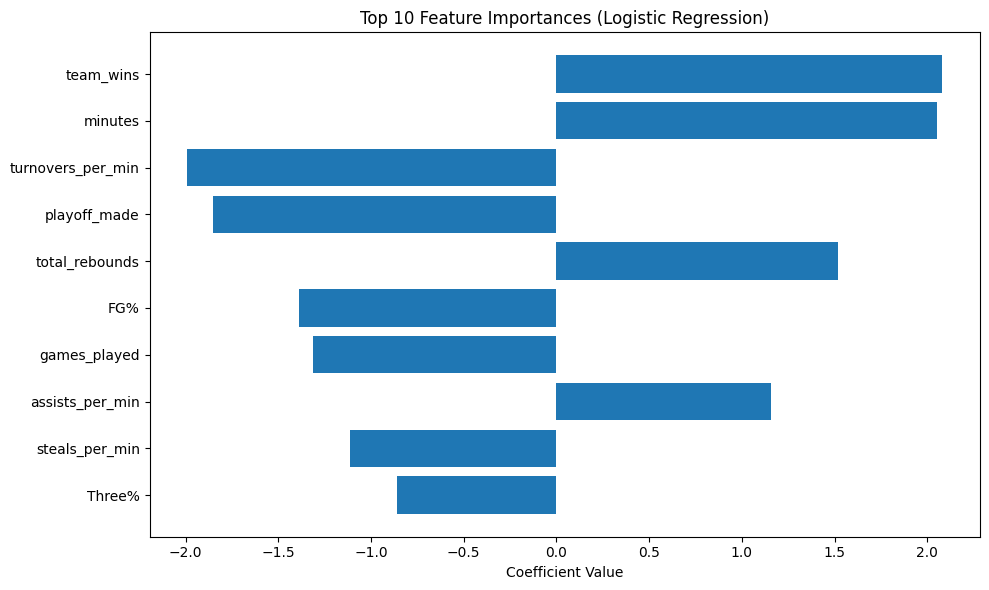

In [176]:
# Get feature importance from coefficients
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'coefficient': model.coef_[0]
}).sort_values('coefficient', key=abs, ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10).to_string(index=False))

# Visualize
plt.figure(figsize=(10, 6))
top_features = feature_importance.head(10)
plt.barh(top_features['feature'], top_features['coefficient'])
plt.xlabel('Coefficient Value')
plt.title('Top 10 Feature Importances (Logistic Regression)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### Top Predictions (Logistic Regression)

In [177]:
# Show top predictions
test_data['lr_prob'] = test_probs
test_data_sorted = test_data.sort_values('lr_prob', ascending=False)

print(f"\nYear {test_award_year} All-Star MVP Predictions (Logistic Regression):")
print(f"{'Rank':<6}{'Player':<20}{'Team':<6}{'Probability':<12}{'Actual'}")
print("-" * 55)
for idx, (_, row) in enumerate(test_data_sorted.head(10).iterrows(), 1):
    actual = "✅ WINNER" if row['Target'] == 1 else ""
    print(f"{idx:<6}{row['playerID']:<20}{row['team']:<6}{row['lr_prob']:.4f}{'':6}{actual}")


Year 2 All-Star MVP Predictions (Logistic Regression):
Rank  Player              Team  Probability Actual
-------------------------------------------------------
1     johnsti01w          HOU   0.9927      
2     mabikmw01w          LAS   0.9927      
3     figgsuk01w          LAS   0.9805      
4     leslili01w          LAS   0.9735      ✅ WINNER
5     willina01w          UTA   0.9619      
6     arcaija01w          HOU   0.8993      
7     penicti01w          SAC   0.8925      
8     thompti01w          HOU   0.8910      
9     clearmi01w          PHO   0.8773      
10    miltode01w          LAS   0.8420      


## 1.2 XGBoost

In [178]:
# Train XGBoost
scale_pos_weight = len(y_train[y_train == 0]) / max(len(y_train[y_train == 1]), 1)

xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    scale_pos_weight=scale_pos_weight,
    max_depth=6,
    learning_rate=0.1,
    n_estimators=100,
    random_state=42,
    verbosity=0
)
xgb_model.fit(X_train, y_train)

# Predictions
y_train_pred_xgb = xgb_model.predict(X_train)
y_test_pred_xgb = xgb_model.predict(X_test)
test_probs_xgb = xgb_model.predict_proba(X_test)[:, 1]

print("\n✅ XGBoost Model trained!")
print(f"Train accuracy: {accuracy_score(y_train, y_train_pred_xgb):.3f}")
print(f"Test accuracy: {accuracy_score(y_test, y_test_pred_xgb):.3f}")
print("\nClassification Report (Test):")
print(classification_report(y_test, y_test_pred_xgb))


✅ XGBoost Model trained!
Train accuracy: 1.000
Test accuracy: 0.978

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.99      0.99      0.99        91
           1       0.00      0.00      0.00         1

    accuracy                           0.98        92
   macro avg       0.49      0.49      0.49        92
weighted avg       0.98      0.98      0.98        92



### Feature Importance (XGBoost)


Top 10 Most Important Features (XGBoost):
        feature  importance
      team_wins    0.494048
            FT%    0.231426
        minutes    0.115593
   games_played    0.048598
assists_per_min    0.023111
 steals_per_min    0.015642
     Three Rate    0.012685
   total_points    0.011631
    team_losses    0.008015
 total_rebounds    0.007460


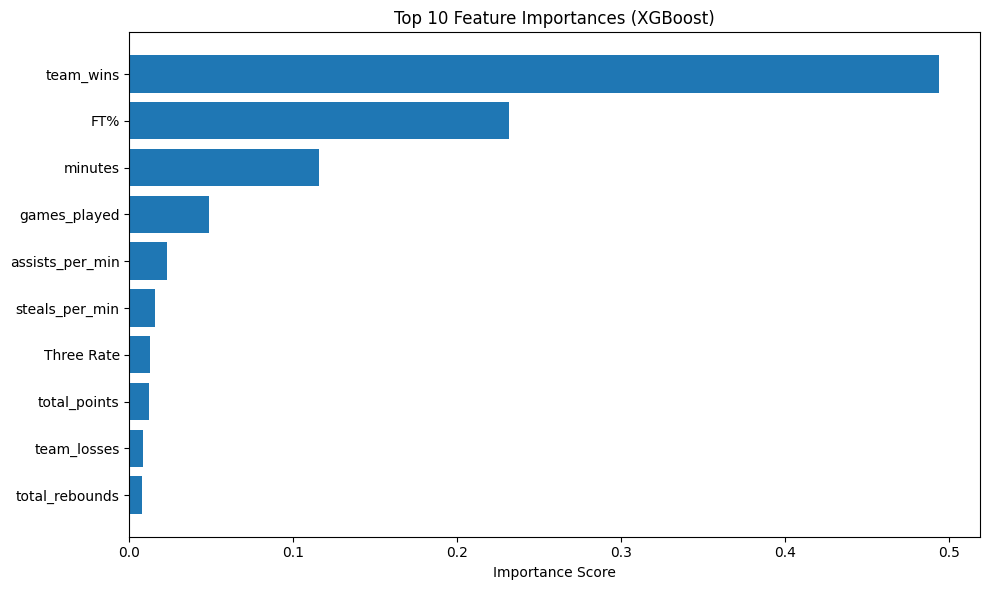

In [179]:
# Get feature importance
feature_importance_xgb = pd.DataFrame({
    'feature': feature_columns,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features (XGBoost):")
print(feature_importance_xgb.head(10).to_string(index=False))

# Visualize
plt.figure(figsize=(10, 6))
top_features_xgb = feature_importance_xgb.head(10)
plt.barh(top_features_xgb['feature'], top_features_xgb['importance'])
plt.xlabel('Importance Score')
plt.title('Top 10 Feature Importances (XGBoost)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### Top Predictions (XGBoost)

In [180]:
# Show top predictions
test_data['xgb_prob'] = test_probs_xgb
test_data_sorted_xgb = test_data.sort_values('xgb_prob', ascending=False)

print(f"\nYear {test_award_year} All-Star MVP Predictions (XGBoost):")
print(f"{'Rank':<6}{'Player':<20}{'Team':<6}{'Probability':<12}{'Actual'}")
print("-" * 55)
for idx, (_, row) in enumerate(test_data_sorted_xgb.head(10).iterrows(), 1):
    actual = "✅ WINNER" if row['Target'] == 1 else ""
    print(f"{idx:<6}{row['playerID']:<20}{row['team']:<6}{row['xgb_prob']:.4f}{'':6}{actual}")


Year 2 All-Star MVP Predictions (XGBoost):
Rank  Player              Team  Probability Actual
-------------------------------------------------------
1     miltode01w          LAS   0.7112      
2     leslili01w          LAS   0.3108      ✅ WINNER
3     mabikmw01w          LAS   0.0502      
4     arcaija01w          HOU   0.0254      
5     figgsuk01w          LAS   0.0122      
6     melvich01w          CLE   0.0106      
7     palmewe01w          DET   0.0095      
8     smithta01w          SAC   0.0092      
9     gilloje01w          PHO   0.0069      
10    johnsti01w          HOU   0.0067      


---
# Section 2: Multi-Year Evaluation (Leave-One-Out Cross-Validation)
Evaluate models across all available years

In [181]:
# Leave-One-Out Cross-Validation Loop
# For each award year T, we train on all other award years
# and predict for year T (which corresponds to Award Year T+1).

award_years = sorted(candidates['next_year'].unique())
results = []

print(f"Running Leave-One-Out Cross-Validation for Award Years {min(award_years)} to {max(award_years)}...")
# Award years are what we're predicting (already correct in next_year column)
print(f"{'Award Year':<12}{'LogReg Acc':<12}{'XGB Acc':<12}{'LogReg Rank':<12}{'XGB Rank':<12}{'Winner'}")
print("-" * 80)

for test_award_year in award_years:
    
    
    # Define Train and Test sets
    train_data_cv = candidates[candidates['next_year'] != test_award_year].copy()
    test_data_cv = candidates[candidates['next_year'] == test_award_year].copy()
    
    if len(test_data_cv) == 0:
        continue
        
    X_train_cv = train_data_cv[feature_columns]
    y_train_cv = train_data_cv['Target']
    X_test_cv = test_data_cv[feature_columns]
    y_test_cv = test_data_cv['Target']
    
    # --- Logistic Regression ---
    scaler_cv = StandardScaler()
    X_train_scaled_cv = scaler_cv.fit_transform(X_train_cv)
    X_test_scaled_cv = scaler_cv.transform(X_test_cv)
    
    lr_model_cv = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
    lr_model_cv.fit(X_train_scaled_cv, y_train_cv)
    
    lr_pred_cv = lr_model_cv.predict(X_test_scaled_cv)
    lr_prob_cv = lr_model_cv.predict_proba(X_test_scaled_cv)[:, 1]
    lr_acc = accuracy_score(y_test_cv, lr_pred_cv)
    
    # --- XGBoost ---
    scale_pos_weight_cv = len(y_train_cv[y_train_cv == 0]) / max(len(y_train_cv[y_train_cv == 1]), 1)
    
    xgb_model_cv = xgb.XGBClassifier(
        objective='binary:logistic',
        scale_pos_weight=scale_pos_weight_cv,
        max_depth=6,
        learning_rate=0.1,
        n_estimators=100,
        random_state=42,
        verbosity=0
    )
    xgb_model_cv.fit(X_train_cv, y_train_cv)
    
    xgb_pred_cv = xgb_model_cv.predict(X_test_cv)
    xgb_prob_cv = xgb_model_cv.predict_proba(X_test_cv)[:, 1]
    xgb_acc = accuracy_score(y_test_cv, xgb_pred_cv)
    
    # --- Check Rank of Actual Winner ---
    test_data_cv['lr_prob'] = lr_prob_cv
    test_data_cv['xgb_prob'] = xgb_prob_cv
    
    actual_winner_row = test_data_cv[test_data_cv['Target'] == 1]
    winner_id = "Unknown"
    lr_rank = "-"
    xgb_rank = "-"
    
    if len(actual_winner_row) > 0:
        winner_id = actual_winner_row.iloc[0]['playerID']
        
        test_data_sorted_lr = test_data_cv.sort_values('lr_prob', ascending=False).reset_index(drop=True)
        lr_rank = test_data_sorted_lr[test_data_sorted_lr['playerID'] == winner_id].index[0] + 1
        
        test_data_sorted_xgb = test_data_cv.sort_values('xgb_prob', ascending=False).reset_index(drop=True)
        xgb_rank = test_data_sorted_xgb[test_data_sorted_xgb['playerID'] == winner_id].index[0] + 1

    print(f"{test_award_year:<12}{lr_acc:.3f}{'':6}{xgb_acc:.3f}{'':6}{lr_rank:<12}{xgb_rank:<12}{winner_id}")
    
    results.append({
        'Award_Year': test_award_year,
        'LR_Acc': lr_acc,
        'XGB_Acc': xgb_acc,
        'LR_Rank': lr_rank if lr_rank != "-" else np.nan,
        'XGB_Rank': xgb_rank if xgb_rank != "-" else np.nan
    })

Running Leave-One-Out Cross-Validation for Award Years 2 to 11...
Award Year  LogReg Acc  XGB Acc     LogReg Rank XGB Rank    Winner
--------------------------------------------------------------------------------
2           0.848      0.978      4           2           leslili01w
3           0.828      0.957      8           4           leslili01w
4           0.846      0.978      43          21          teaslni01w
5           0.818      0.989      -           -           Unknown
6           0.947      0.987      61          35          swoopsh01w
7           0.861      0.987      16          7           douglka01w
8           0.857      0.978      24          11          fordch01w
9           0.901      0.988      -           -           Unknown
10          0.843      0.989      22          81          cashsw01w
11          0.908      1.000      -           -           Unknown


## Summary of Multi-Year Results

In [182]:
results_df = pd.DataFrame(results)

print("\nAverage Performance:")
print(f"Logistic Regression Accuracy: {results_df['LR_Acc'].mean():.3f}")
print(f"XGBoost Accuracy:             {results_df['XGB_Acc'].mean():.3f}")
print(f"Logistic Regression Avg Rank: {results_df['LR_Rank'].mean():.1f}")
print(f"XGBoost Avg Rank:             {results_df['XGB_Rank'].mean():.1f}")

best_model = "Logistic Regression" if results_df['LR_Rank'].mean() < results_df['XGB_Rank'].mean() else "XGBoost"
print(f"\n🏆 Recommended Model: {best_model}")


Average Performance:
Logistic Regression Accuracy: 0.866
XGBoost Accuracy:             0.983
Logistic Regression Avg Rank: 25.4
XGBoost Avg Rank:             23.0

🏆 Recommended Model: XGBoost


---
# Section 3: Predict for New Year
Use this section to predict All-Star MVP for a future year using past data

## 3.1 Train Final Models on All Available Data

In [183]:
# Train on ALL available data (years 1-10)
all_train_data = candidates[candidates['year'].isin([1,2,3,4,5,6,7,8,9,10])].copy()
X_all = all_train_data[feature_columns]
y_all = all_train_data['Target']

# Train Logistic Regression
scaler_final = StandardScaler()
X_all_scaled = scaler_final.fit_transform(X_all)
model_final = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
model_final.fit(X_all_scaled, y_all)

# Train XGBoost
scale_pos_weight_final = len(y_all[y_all == 0]) / max(len(y_all[y_all == 1]), 1)
xgb_model_final = xgb.XGBClassifier(
    objective='binary:logistic',
    scale_pos_weight=scale_pos_weight_final,
    max_depth=6,
    learning_rate=0.1,
    n_estimators=100,
    random_state=42,
    verbosity=0
)
xgb_model_final.fit(X_all, y_all)

print("✅ Final models trained on all available data (Years 1-10)")

✅ Final models trained on all available data (Years 1-10)


## 3.2 Load New Year Data and Predict

In [ ]:
# Predict All-Star MVP for new year using previous year stats
# Example: year_10_players_teams_test.csv → use year 9 stats → predict year 10 All-Star MVP

new_year_file = "../../yearly_data/year_10_players_teams_test.csv"
predict_year = 10
stats_year = predict_year - 1

print(f"Predicting Year {predict_year} All-Star MVP using Year {stats_year} stats")

# Load new year player list
new_year_players = pd.read_csv(new_year_file)
print(f"Players in year {predict_year}: {len(new_year_players)}")

# Get year N-1 stats for these players
player_stats = mvp_data[
    (mvp_data['year'] == stats_year) &
    (mvp_data['playerID'].isin(new_year_players['playerID']))
].copy()

# Filter to All-Star MVP candidates
new_candidates = player_stats[
    (player_stats['minutes'] >= 500) &
    (player_stats['games_played'] >= 20)
].copy()

print(f"All-Star MVP candidates: {len(new_candidates)}")

Predicting Year 2 All-Star MVP using Year 1 stats
Players in year 2: 208
All-Star MVP candidates: 84


### Predictions with Logistic Regression

In [185]:
# Predict with Logistic Regression
X_new = new_candidates[feature_columns]
X_new_scaled = scaler_final.transform(X_new)
new_candidates['lr_probability'] = model_final.predict_proba(X_new_scaled)[:, 1]
new_candidates_sorted_lr = new_candidates.sort_values('lr_probability', ascending=False)

print(f"\nYear {predict_year} All-Star MVP Predictions (Logistic Regression):")
print(f"{'Rank':<6}{'Player':<25}{'Team':<6}{'Probability':<12}{'PPG':<8}{'Wins'}")
print("-" * 70)
for idx, (_, row) in enumerate(new_candidates_sorted_lr.head(15).iterrows(), 1):
    ppg = row['total_points'] / row['games_played']
    print(f"{idx:<6}{row['playerID']:<25}{row['team']:<6}{row['lr_probability']:.4f}{'':6}{ppg:.1f}{'':6}{int(row['team_wins'])}")

print(f"\n🏆 Predicted All-Star MVP (LR): {new_candidates_sorted_lr.iloc[0]['playerID']}")


Year 2 All-Star MVP Predictions (Logistic Regression):
Rank  Player                   Team  Probability PPG     Wins
----------------------------------------------------------------------
1     mabikmw01w               LAS   0.9902      12.3      28
2     johnsti01w               HOU   0.9802      4.2      27
3     leslili01w               LAS   0.9778      17.8      28
4     figgsuk01w               LAS   0.9628      6.7      28
5     willina01w               UTA   0.9323      18.7      18
6     penicti01w               SAC   0.8498      6.9      21
7     thompti01w               HOU   0.8290      16.9      27
8     arcaija01w               HOU   0.7989      8.4      27
9     miltode01w               LAS   0.7411      11.8      28
10    clearmi01w               PHO   0.7162      2.4      20
11    boltoru01w               SAC   0.6700      13.1      21
12    dixonta01w               LAS   0.5517      10.9      28
13    smithka01w               MIN   0.5401      20.2      15
14    john

### Predictions with XGBoost

In [186]:
# Predict with XGBoost
new_candidates['xgb_probability'] = xgb_model_final.predict_proba(X_new)[:, 1]
new_candidates_sorted_xgb = new_candidates.sort_values('xgb_probability', ascending=False)

print(f"\nYear {predict_year} All-Star MVP Predictions (XGBoost):")
print(f"{'Rank':<6}{'Player':<25}{'Team':<6}{'Probability':<12}{'PPG':<8}{'Wins'}")
print("-" * 70)
for idx, (_, row) in enumerate(new_candidates_sorted_xgb.head(15).iterrows(), 1):
    ppg = row['total_points'] / row['games_played']
    print(f"{idx:<6}{row['playerID']:<25}{row['team']:<6}{row['xgb_probability']:.4f}{'':6}{ppg:.1f}{'':6}{int(row['team_wins'])}")

print(f"\n🏆 Predicted All-Star MVP (XGBoost): {new_candidates_sorted_xgb.iloc[0]['playerID']}")


Year 2 All-Star MVP Predictions (XGBoost):
Rank  Player                   Team  Probability PPG     Wins
----------------------------------------------------------------------
1     leslili01w               LAS   0.9984      17.8      28
2     miltode01w               LAS   0.0865      11.8      28
3     mabikmw01w               LAS   0.0618      12.3      28
4     dixonta01w               LAS   0.0519      10.9      28
5     maxwemo01w               IND   0.0104      10.4      9
6     griffyo01w               SAC   0.0061      16.3      21
7     clearmi01w               PHO   0.0042      2.4      20
8     arcaija01w               HOU   0.0036      8.4      27
9     johnsti01w               HOU   0.0034      4.2      27
10    boltoru01w               SAC   0.0033      13.1      21
11    willina01w               UTA   0.0032      18.7      18
12    figgsuk01w               LAS   0.0026      6.7      28
13    smithta01w               SAC   0.0026      12.1      21
14    goodsad01w      

### Check Actual Winner (if available)

In [187]:
# Check if we have the actual winner for this year
actual_winner = mvp_data[(mvp_data['year'] == predict_year) & (mvp_data['MVP_winner'] == 1)]

if len(actual_winner) > 0:
    actual_mvp_id = actual_winner.iloc[0]['playerID']
    print(f"\n✅ Actual All-Star MVP for Year {predict_year}: {actual_mvp_id}")
    
    # Check if actual winner is in our predictions
    lr_prob_actual = new_candidates[new_candidates['playerID'] == actual_mvp_id]['lr_probability']
    xgb_prob_actual = new_candidates[new_candidates['playerID'] == actual_mvp_id]['xgb_probability']
    
    if len(lr_prob_actual) > 0:
        lr_rank_actual = new_candidates_sorted_lr[new_candidates_sorted_lr['playerID'] == actual_mvp_id].index[0] + 1
        print(f"   Logistic Regression - Rank: {lr_rank_actual}, Probability: {lr_prob_actual.values[0]:.4f}")
    
    if len(xgb_prob_actual) > 0:
        xgb_rank_actual = new_candidates_sorted_xgb[new_candidates_sorted_xgb['playerID'] == actual_mvp_id].index[0] + 1
        print(f"   XGBoost - Rank: {xgb_rank_actual}, Probability: {xgb_prob_actual.values[0]:.4f}")
else:
    print(f"\n⚠️ No actual winner data available for Year {predict_year}")


✅ Actual All-Star MVP for Year 2: leslili01w
   Logistic Regression - Rank: 904, Probability: 0.9778
   XGBoost - Rank: 904, Probability: 0.9984
